In [3]:
import numpy as np
from scipy import stats
from scipy . optimize import curve_fit
from scipy . interpolate import interp1d
from scipy import optimize
from astropy.io import fits #allows python to interpurt fits data files 
from glob import glob # Unix style pathname pattern expansion
import uncertainties
from astropy.stats import sigma_clip
from uncertainties import ufloat_fromstr
# from uncertainties.umath import
from uncertainties import unumpy as unp 
# from exoctk.lightcurve_fitting.lightcurve import LightCurve
# from exoctk.lightcurve_fitting.parameters import Parameters
# from exoctk.lightcurve_fitting.models import PolynomialModel, TransitModel
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# --- plot parameters --- 
plt.rcParams["figure.figsize"] = (15,10)
plt.rc('font', family = 'serif', serif = 'cmr10') 
plt.rcParams.update({'font.size': 22})

In [5]:
exp = [60, 60, 60, 60, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]
print(len(exp))

18


In [2]:
# --- Functions --- 

def master_sigma(name, a, b, x, y, std): 
    
    files = glob(name)

    print(len(files))
    
    #defining arrays and variables 
    all_data = []
    i = 0 
    
    while i < len(files):
        # using a loop to obtain data for all pixels 
        pixel_data = np.delete((fits.open(files[i])[0].data[a:b, x:y]),  np.s_[0:50], axis = 1)
        all_data.append(pixel_data)
        print(np.shape(all_data))
        i += 1
        
    all_data_array = np.asarray(all_data)
    print(np.shape(all_data_array))
    
    all_data_transposed = np.concatenate(np.swapaxes((all_data_array), 0, 2)) #transposing data to sigma clip
    
    i = 0 #resetting counter 
    clipped_data = []

    while i < len(all_data_transposed):
        clipped_data.append(sigma_clip(all_data_transposed[i], sigma = std))
        i +=1
        
    clipped_data_transposed = np.asarray(clipped_data)
   
    clipped_data_3D = np.swapaxes(np.array_split(clipped_data_transposed, len(all_data_array[0][1])), 2, 0)
    print(np.shape(clipped_data_3D))
    
    nonzero = np.nonzero(clipped_data_3D == 0)
    count = np.count_nonzero(nonzero)
    print(count) #counts number of clipped pixel in sample set 
    
    return np.average(clipped_data_3D, axis = 0)    

In [3]:
shape = np.shape(fits.getdata('lab_data/Ser/flats/clear/F120308_0022.fits'))

max_x = shape[0]
min_y = shape[1]

In [4]:
%%time
master_flat = master_sigma('lab_data/Ser/flats/clear/F120308*', 0, max_x, 0, min_y, 3)

7
(1, 2048, 2048)
(2, 2048, 2048)
(3, 2048, 2048)
(4, 2048, 2048)
(5, 2048, 2048)
(6, 2048, 2048)
(7, 2048, 2048)
(7, 2048, 2048)
(7, 2048, 2048)
0
Wall time: 7min 33s


In [ ]:
fits.PrimaryHDU(master_flat).writeto('clipped_NNSer/master_flat', overwrite = True)

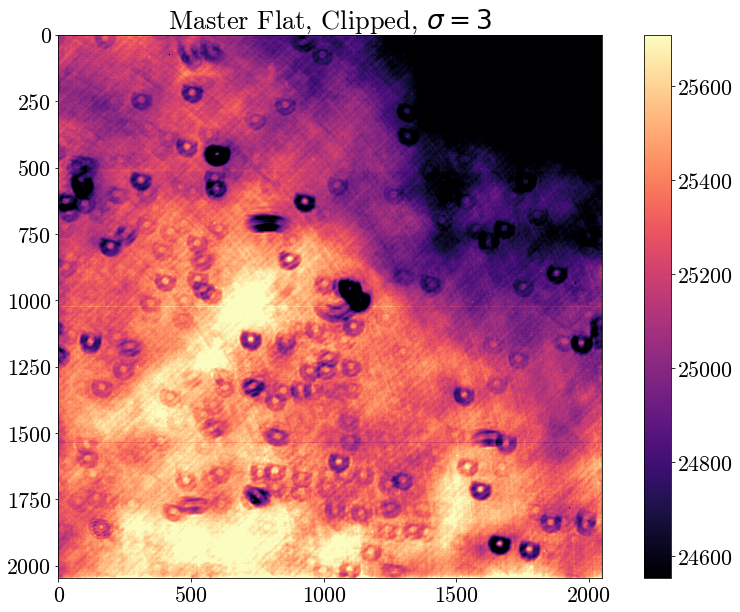

In [13]:
master_flat = fits.getdata('clipped_NNSer/master_flat')

vmax = master_flat.mean() + master_flat.std()
vmin = master_flat.mean() - master_flat.std()

plt.title('Master Flat, Clipped, $\sigma = 3$')
plt.imshow(master_flat, cmap = 'magma', vmax= vmax, vmin= vmin)
plt.colorbar()

### Light Curve Fit and Errors

In [6]:
magnitude, LM, seconds  = np.loadtxt("saved_data/light_curve.dat", unpack = True) 
SN, SN_sig, ZP_sig, SNLM, LM_sig = np.loadtxt("saved_data/light_curve_err.dat", unpack = True) 

seconds = seconds + exp
seconds = seconds - seconds[0]
mins = seconds/60

# --- error prop --- 

time_err = np.diff(mins)
print(np.shape(time_err))
time_err = np.append(time_err, time_err.mean())
print(np.shape(time_err))
time_err = time_err/2 

# -- func more than one var --- 

mag_err = np.sqrt(SN_sig**2 + ZP_sig**2)
LM_err =  np.sqrt(LM_sig**2 + ZP_sig**2)

(17,)
(18,)


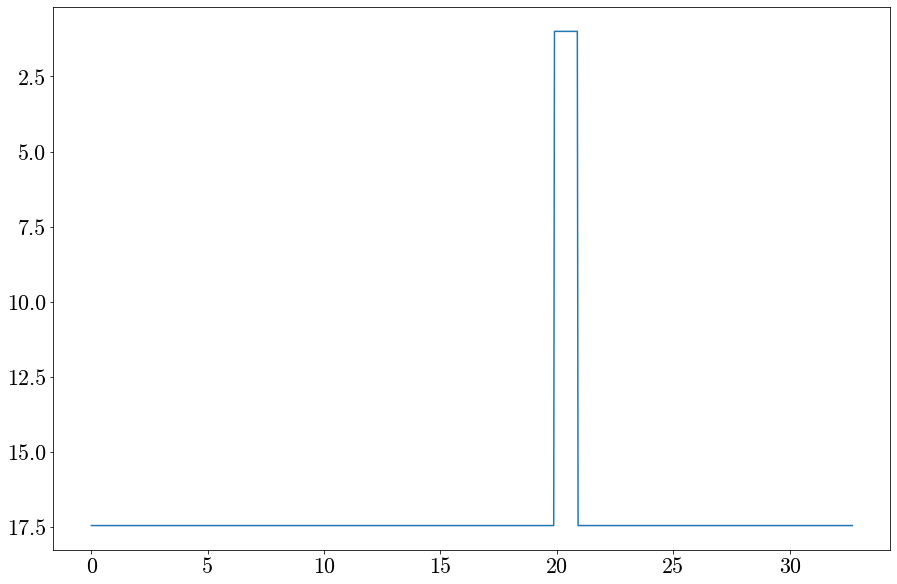

In [202]:
def sine_func(x, y, z): 
    return y*np.sin(x*z)

def lin_func(x, m, c):
    return m*x + c #equation of a line y = mx + c 

def log(a, b, x):
    return np.exp(a)*np.exp(b*x)

def quad_func(a, b, c, x):
    return a*(x**2) + b*(x) + c 

def tophat(x, base_level, hat_level, hat_mid, hat_width):
    return np.where((hat_mid - hat_width/2. < x) & (x < hat_mid + hat_width/2.), hat_level, base_level)


# --- Calculating Optimum Parameters and Covariance Matrix ---

popt1, pcov1 = curve_fit(lin_func, mins, LM)
LM_F = lin_func(mins, popt1[0], popt1[1])

mins_s = np.linspace(mins.min(), mins.max(), 1000)

# --- 
a = magnitude[0:5]
b = magnitude[12:18]

baseline = (np.concatenate((a, b), axis=0)).mean()

midpoint = mins[6:11].min() + (mins[6:11].max() - mins[6:11].min())/2 

tphat = tophat(mins_s, baseline, 1, midpoint, 1)

tpaht = np.abs(tphat)
plt.plot(mins_s, tpaht)
plt.gca().invert_yaxis()


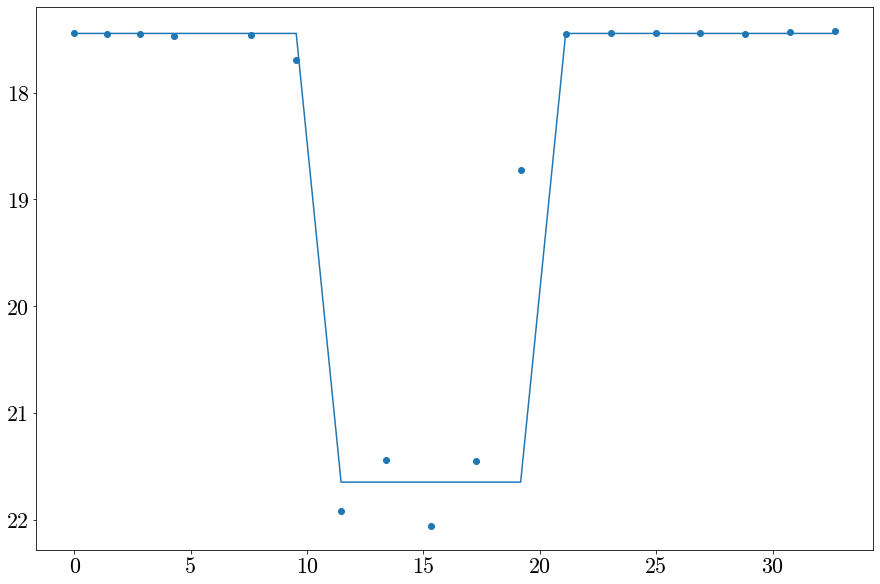

In [355]:

from astropy.modeling.models import Box1D

# --- Box1D (amp, baseline, width 1)

a = magnitude[0:5]
b = magnitude[12:18]

baseline = (np.concatenate((a, b), axis=0)).mean()

amp = magnitude[7:10].mean() - baseline 

midpoint = mins.max()/2 

hat = Box1D(amp, midpoint - 1, 10)

x = mins

init = Box1D()

y = hat(x) + baseline

plt.gca().invert_yaxis()
plt.scatter(mins, magnitude)
plt.plot(x, y)

Text(0, 0.5, 'Magnitude')

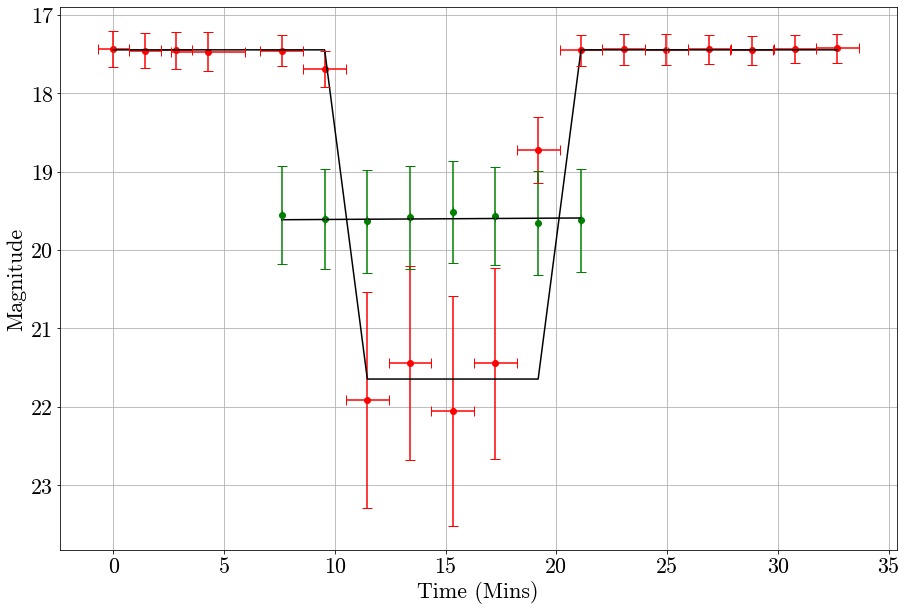

In [380]:

LM_fit = func(mins)


# --- Plot Data points --- 

plt.scatter(mins, magnitude, color = 'red')
plt.scatter(mins[4:12], LM[4:12], color  = 'green')

# --- Plotting the Data using straight fitted functions --- 

plt.plot(mins[4:12], LM_F[4:12], color = 'black') #using calculated parameters to plot best fit


# plt.plot(mins_s, tpaht)

plt.plot(x, y, color = 'black')

plt.grid()
plt.gca().invert_yaxis()

plt.errorbar(mins, magnitude, xerr = time_err, yerr = .15*mag_err, capsize= 5, ls='none', color = 'red')
plt.errorbar(mins[4:12], LM[4:12], xerr = 0, yerr = .15*LM_err[4:12], capsize= 5, ls='none', color = 'green')
plt.xlabel('Time (Mins)')
plt.ylabel('Magnitude')

In [381]:
# --- finding duration --- 

# print(x)
print(mins[4:12])

a = 9.536 + (9.536 - 7.603)/2
b = 19.179 + (21.113 - 19.179)/2 


print(a, b)

print(b - a) 

[ 7.60363333  9.53646667 11.46413333 13.39248333 15.31906667 17.24876667
 19.179      21.113     ]
10.5025 20.146
9.643500000000001


In [8]:
# --- Calculation and Uncertainty on Eclipse time --- 
mins_err =  unp.uarray(mins, time_err)
# print(mins_err.mean())

c1 = mins_err[4:6] 
c2 = mins_err[10:12]

# print(c1, c2)

p1 = c1[0]
p2 = c1[1]

p3 = c2[0]
p4 = c2[1]


ES = p2 + (p2 - p1)/2 
EE = p4 + (p4 - p3)/2 

print(ES, EE)

print('Eclipse duration in mins:', EE - ES)

10.5+/-1.5 22.1+/-1.5
Eclipse duration in mins: 11.6+/-2.2


Text(0, 0.5, 'Magnitude')

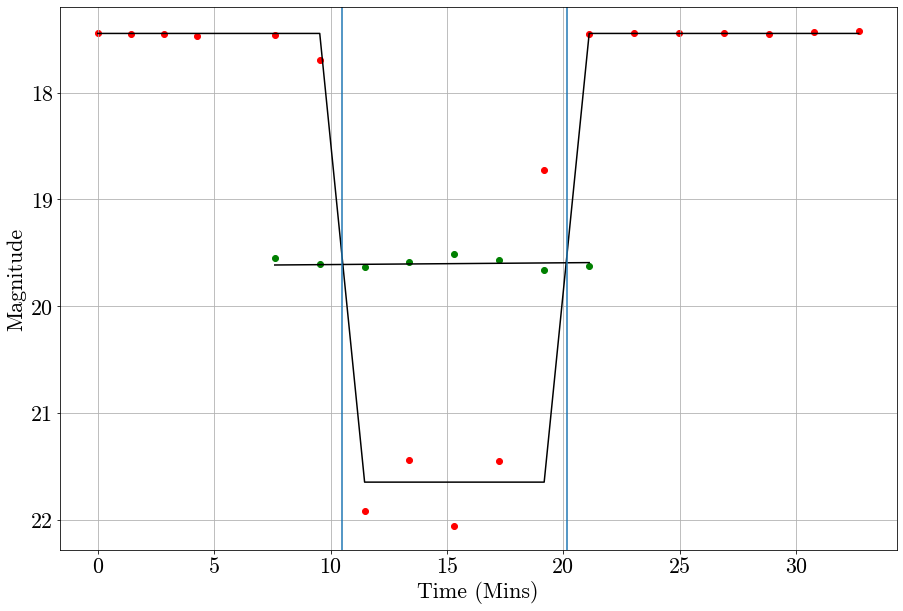

In [383]:
# --- Plot Data points --- 

plt.scatter(mins, magnitude, color = 'red')
plt.scatter(mins[4:12], LM[4:12], color  = 'green')

# --- Plotting the Data using straight fitted functions --- 

plt.plot(mins[4:12], LM_F[4:12], color = 'black') #using calculated parameters to plot best fit


# plt.plot(mins_s, tpaht)

plt.plot(x, y, color = 'black')

plt.grid()
plt.gca().invert_yaxis()

plt.axvline(x = a)
plt.axvline(x = b)
# plt.fill_betweenx(mins, a, x2 = b, alpha = '.5') 

# plt.errorbar(mins, magnitude, xerr = time_err, yerr = .15*mag_err, capsize= 5, ls='none', color = 'red')
# plt.errorbar(mins[4:12], LM[4:12], xerr = 0, yerr = .15*LM_err[4:12], capsize= 5, ls='none', color = 'green')
plt.xlabel('Time (Mins)')
plt.ylabel('Magnitude')

### Errors

In [384]:
def SN(source_counts, sky_counts, pixels_source, pixels_sky, R):
    return source_counts(source_counts + pixels_source*(1 + (pixels_source/pixels_sky))*(sky_counts + R**2))

def SNsig(SN):
    return 2.5*np.log(1 + 1/SN) 